# Chapter 5: Compressing Data via Dimensionality Reduction

## Unsupervised dimensionality reduction via principal component analysis

### PCA - Principal Component Analysis

**Algorytm PCA (Principal Component Analysis)** to technika statystyczna i metoda redukcji wymiarów, której celem jest uproszczenie danych poprzez projekcję ich na nową przestrzeń o mniejszej liczbie wymiarów. PCA jest szeroko stosowane w analizie danych, wizualizacji oraz wstępnym przetwarzaniu danych przed zastosowaniem algorytmów uczenia maszynowego.

Jak działa PCA?

1. **Standaryzacja danych:** Pierwszym krokiem w PCA jest często standaryzacja danych, czyli przekształcenie danych tak, aby miały średnią 0 i wariancję 1 dla każdego wymiaru (cechy). To ważne, ponieważ PCA jest wrażliwe na różnice w skali poszczególnych cech.

2. **Obliczenie macierzy kowariancji:** Następnie oblicza się macierz kowariancji, która pokazuje, jak poszczególne cechy są ze sobą powiązane. Kowariancja mierzy, jak zmiana jednej cechy wpływa na drugą. Dla wysokiej kowariancji między dwoma cechami oznacza to, że zmieniają się one w podobny sposób.

3. **Obliczenie wektorów własnych i wartości własnych:** Następnie na podstawie macierzy kowariancji oblicza się wektory własne (które są kierunkami głównych składowych) oraz odpowiadające im wartości własne (które wskazują na "ważność" tych kierunków, tj. ilość wariancji, którą dane kierunki wyjaśniają).

4. **Wybór głównych składowych:**Wektory własne są uporządkowane według wartości własnych (od największej do najmniejszej). Główne składowe to kierunki o największej wariancji, co oznacza, że te kierunki najlepiej uchwycają strukturę danych. W zależności od potrzeb możemy wybrać tylko kilka głównych składowych, aby zredukować liczbę wymiarów.

5. **Projekcja danych na nowe osie:** Na końcu projektujemy oryginalne dane na wybrane główne składowe. Otrzymujemy nową reprezentację danych w przestrzeni o mniejszej liczbie wymiarów.

### Extracting the principal components step-by-step
In this subsection, we will tackle the first four steps of a PCA:
1. Standardizing the data
2. Constructing the covariance matrix
3. Obtaining the eigenvalues and eigenvectors of the covariance matrix
4. Sorting the eigenvalues by decreasing order to rank the eigenvectors

**Loading wine dataset**

In [1]:

import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


**Splitting into training and testing set**

In [2]:

from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

**Standarizing the fearures**

In [3]:

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

**Eigendecomposition of the covariance matrix**

In [4]:
import numpy as np
cov_mat=np.cov(X_train_std.T)
eigen_vals,eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n', eigen_vals)


Eigenvalues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


**Note:**

Above, I used the numpy.linalg.eig function to decompose the symmetric covariance matrix into its eigenvalues and eigenvectors.

>>> `eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)`


This is not really a "mistake," but probably suboptimal. It would be better to use numpy.linalg.eigh in such cases, which has been designed for Hermetian matrices. The latter always returns real eigenvalues; whereas the numerically less stable np.linalg.eig can decompose nonsymmetric square matrices, you may find that it returns complex eigenvalues in certain cases.

### Total and explained variance

Since we want to reduce the dimensionality of our dataset by compressing it onto a new feature subspace,
we only select the subset of the eigenvectors (principal components) that contains most of the
information (variance). The eigenvalues define the magnitude of the eigenvectors, so we have to sort the
eigenvalues by decreasing magnitude; we are interested in the top k eigenvectors based on the values
of their corresponding eigenvalues. But before we collect those k most informative eigenvectors, let’s
plot the variance explained ratios of the eigenvalues. The variance explained ratio of an eigenvalue,
𝜆𝑗, is simply the fraction of an eigenvalue, 𝜆𝑗, and the total sum of the eigenvalues

Using the NumPy cumsum function, we can then calculate the cumulative sum of explained variances,
which we will then plot via Matplotlib’s step function:

In [5]:
total_sum = sum(eigen_vals)
var_exp = [(i/total_sum) for i in sorted(eigen_vals,reverse=True)]
cumulative_var_exp = np.cumsum(var_exp)
cumulative_var_exp

array([0.36951469, 0.55386396, 0.67201555, 0.74535807, 0.80957914,
       0.86009639, 0.89964293, 0.92608211, 0.9499753 , 0.96627144,
       0.98007165, 0.99179391, 1.        ])

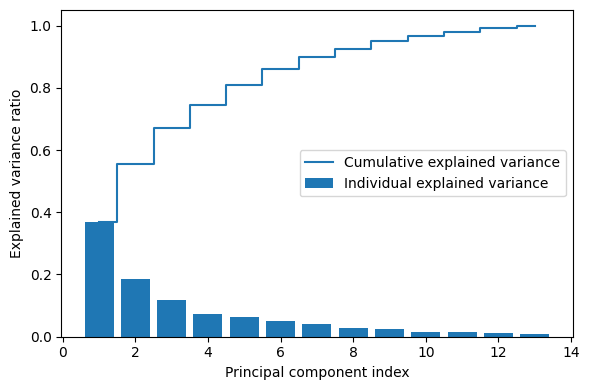

In [6]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(6,4))
ax.bar(range(1,14),var_exp,align='center',label='Individual explained variance')

ax.step(range(1,14),cumulative_var_exp,where='mid',label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The resulting plot indicates that the first principal component alone accounts for approximately 40
percent of the variance.
Also, we can see that the first two principal components combined explain almost 60 percent of the
variance in the dataset

### Feature transformation

Now that we have successfully decomposed the covariance matrix into eigenpairs, let’s proceed with
the last three steps to transform the Wine dataset onto the new principal component axes. The remaining
steps we are going to tackle in this section are the following:
1. Select k eigenvectors, which correspond to the k largest eigenvalues, where k is the dimensionality
of the new feature subspace (𝑘<d).
2. Construct a projection matrix, W, from the “top” k eigenvectors.
3. Transform the d-dimensional input dataset, X, using the projection matrix, W, to obtain the
new k-dimensional feature subspace.

Or, in less technical terms, we will sort the eigenpairs by descending order of the eigenvalues, construct
a projection matrix from the selected eigenvectors, and use the projection matrix to transform
the data onto the lower-dimensional subspace.

**Sorting the eigenpairs by decreasing order of the eigenvalues:**

In [7]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[:,i]) for i in
range(len(eigen_vals))]
#Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

Next, we collect the two eigenvectors that correspond to the two largest eigenvalues, to capture about
60 percent of the variance in this dataset. Note that two eigenvectors have been chosen for the purpose
of illustration, since we are going to plot the data via a two-dimensional scatterplot later in this subsection.
In practice, the number of principal components has to be determined by a tradeoff between
computational efficiency and the performance of the classifier:

In [8]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


By executing the preceding code, we have created a 13×2-dimensional projection matrix, W, from the
top two eigenvectors.

Using the projection matrix, we can now transform an example, x (represented as a 13-dimensional
row vector), onto the PCA subspace (the principal components one and two)

In [9]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

Similarly, we can transform the entire 124×13-dimensional training dataset onto the two principal
components by calculating the matrix dot product

In [10]:
X_train_pca = X_train_std.dot(w)

Lastly, let’s visualize the transformed Wine training dataset, now stored as an 124×2-dimensional
matrix, in a two-dimensional scatterplot:

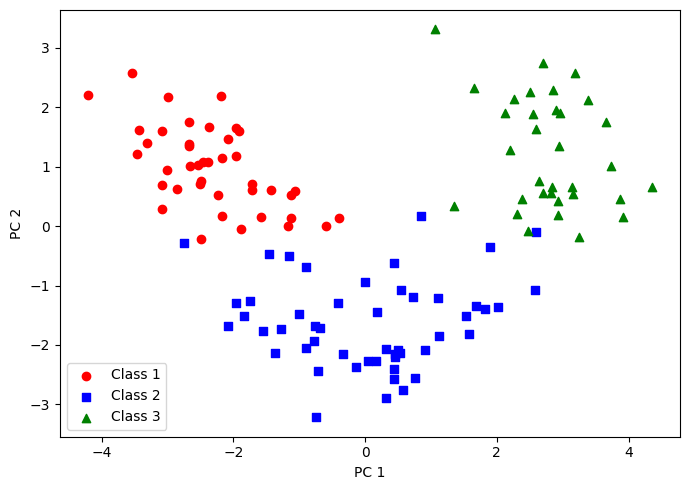

In [11]:
colors=['r','b','g']
markers=['o','s','^']
fig,ax = plt.subplots(figsize=(7,5))
for l,c,m in zip(np.unique(y_train),colors,markers):
    ax.scatter(X_train_pca[y_train==l,0],X_train_pca[y_train==l,1],c=c,label=f'Class {l}', marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### Principal component analysis in scikit-learn

Now, let’s use the PCA class from scikit-learn on the Wine training dataset,
classify the transformed examples via logistic regression, and visualize the decision regions via the
plot_decision_regions function that we defined in Chapter 2.

In [12]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
# setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

**Training logistic regression classifier using the first 2 principal components.**

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


**Plot fot training set**

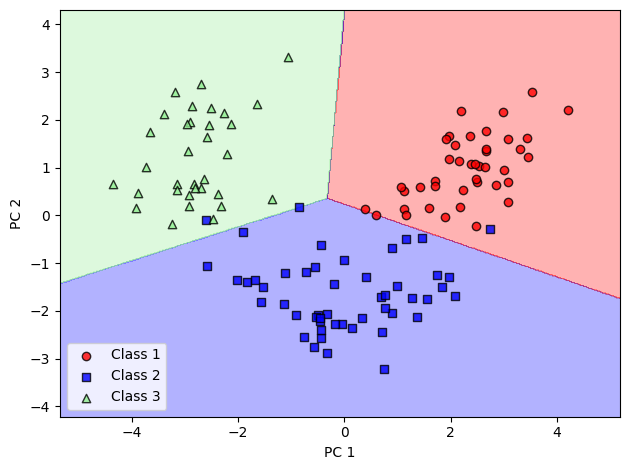

In [14]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

**Plot fot testing set**

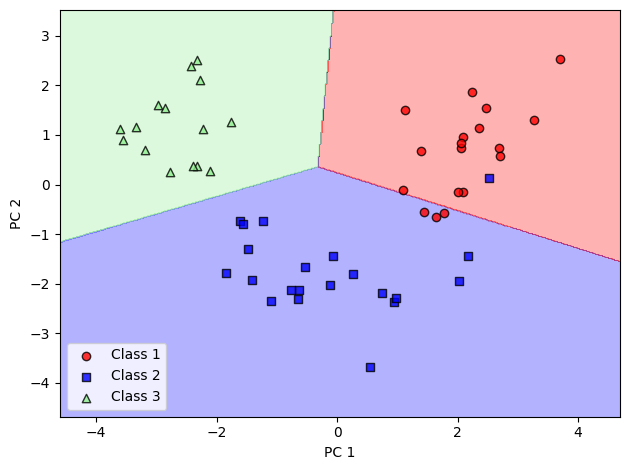

In [15]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

If we are interested in the explained variance ratios of the different principal components, we can
simply initialize the PCA class with the n_components parameter set to None, so all principal components
are kept and the explained variance ratio can then be accessed via the explained_variance_ratio_
attribute:

In [16]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

Note that we set n_components=None when we initialized the PCA class so that it will return all principal
components in a sorted order, instead of performing a dimensionality reduction.

### Assessing feature contributions

We plot the loadings for the first principal component, loadings[:, 0], which is the first column
in this matrix:

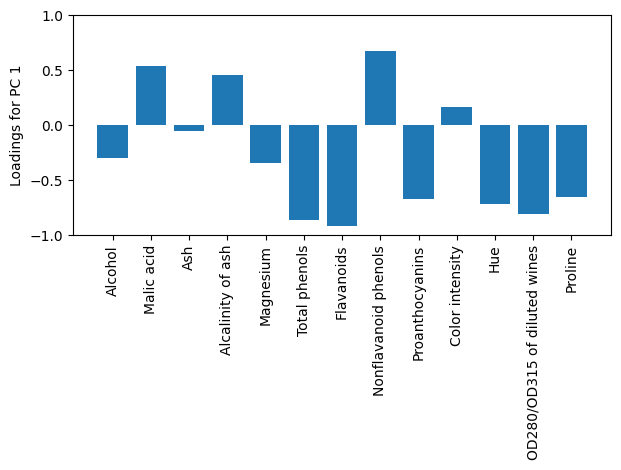

In [18]:
loadings = eigen_vecs * np.sqrt(eigen_vals)

fig, ax = plt.subplots()

ax.bar(range(13), loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

We can see that, for example, Alcohol has a negative correlation with the first principal
component (approximately –0.3), whereas Malic acid has a positive correlation (approximately 0.54).
Note that a value of 1 describes a perfect positive correlation whereas a value of –1 corresponds to a
perfect negative correlation

In [19]:
loadings[0]

array([-0.3020184 ,  0.78189545, -0.17141048, -0.00323153, -0.26662574,
        0.24336696,  0.05691178, -0.21672546, -0.22292631, -0.03098632,
        0.17313511, -0.05010532,  0.11177761])

In the preceding code example, we compute the factor loadings for our own PCA implementation.
We can obtain the loadings from a fitted scikit-learn PCA object in a similar manner, where pca.
components_ represents the eigenvectors and pca.explained_variance_ represents the eigenvalues:

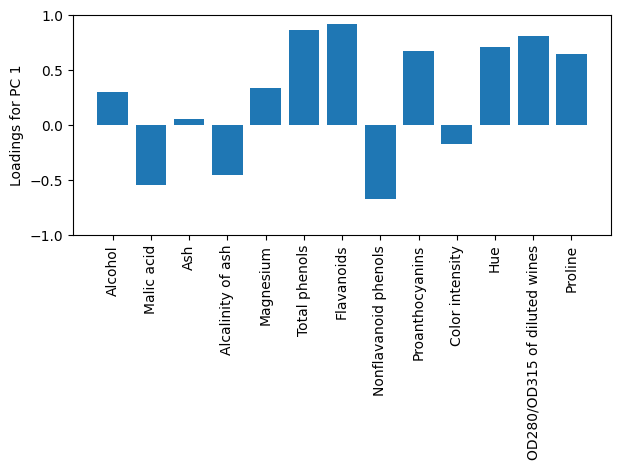

In [21]:
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig, ax = plt.subplots()

ax.bar(range(13), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

In [23]:
sklearn_loadings[0]

array([ 0.3020184 ,  0.78189545, -0.17141048, -0.00323153, -0.26662574,
        0.24336696, -0.05691178,  0.21672546, -0.22292631, -0.17313511,
       -0.11177761, -0.05010532,  0.03098632])

Minus nic nie zmienia więc to samo

## Supervised data compression via linear discriminant analysis

### Linear Discriminant Analysis (LDA) – Analiza Dyskryminacyjna
Linear Discriminant Analysis (LDA) to technika stosowana w statystyce i uczeniu maszynowym do redukcji wymiarów i klasyfikacji. Jest podobna do PCA (Principal Component Analysis), ale różni się celem:

- PCA maksymalizuje wariancję danych,
- LDA maksymalizuje separację klas, szukając takich kierunków, które najlepiej rozróżniają różne grupy danych.


### The inner workings of linear discriminant analysis
Before we dive into the code implementation, let’s briefly summarize the main steps that are required
to perform LDA:
1. Standardize the d-dimensional dataset (d is the number of features).
2. For each class, compute the d-dimensional mean vector.
3. Construct the between-class scatter matrix, SB, and the within-class scatter matrix, SW.
4. Compute the eigenvectors and corresponding eigenvalues of the matrix, 𝑺𝑊^−1𝑺𝐵 .
5. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
6. Choose the k eigenvectors that correspond to the k largest eigenvalues to construct a d×k-dimensional
transformation matrix, W; the eigenvectors are the columns of this matrix.
7. Project the examples onto the new feature subspace using the transformation matrix, W.

As we can see, LDA is quite similar to PCA in the sense that we are decomposing matrices into eigenvalues
and eigenvectors, which will form the new lower-dimensional feature space. However, as
mentioned before, LDA **takes class label information into account,** which is represented in the form
of the mean vectors computed in step 2.

### Computing the scatter matrices
Since we already standardized the features of the Wine dataset in the PCA section at the beginning of
this chapter, we can skip the first step and proceed with the calculation of the mean vectors, which
we will use to construct the within-class scatter matrix and between-class scatter matrix, respectively.

**Calculating mean vectors**

In [25]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4): # klasy 1-3
  mean_vecs.append(np.mean(X_train_std[y_train==label],axis=0))
  print(f'Mean vector class {label}: {mean_vecs[label-1]}\n')

Mean vector class 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

Mean vector class 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

Mean vector class 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



**Using the mean vectors, we can now compute the within-class scatter matrix S_W**

In [26]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T) # wzor w ksiazce
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: '
      f'{S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 13x13


The assumption that we are making when we are computing the scatter matrices is that the class labels
in the training dataset are uniformly distributed. However, if we print the number of class labels, we
see that this assumption is violated:

> Uniformly distributed (jednolicie rozłożony) oznacza, że wartości w danym zakresie są równomiernie rozłożone, czyli każda wartość ma takie samo prawdopodobieństwo wystąpienia.



In [27]:
print('Class label distribution:',
      np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


Thus, we want to scale the individual scatter matrices, Si, before we sum them up as the scatter matrix,
SW. When we divide the scatter matrices by the number of class-examples, ni, we can see that computing
the scatter matrix is in fact the same as computing the covariance matrix, Σ𝑖 —the covariance
matrix is a normalized version of the scatter matrix

**The code for computing the scaled within-class scatter matrix**

In [28]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

print('Scaled within-class scatter matrix: '
      f'{S_W.shape[0]}x{S_W.shape[1]}')

Scaled within-class scatter matrix: 13x13


**Compute the between-class scatter matrix SB**

In [29]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)  # make column vector

d = 13  # number of features
S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: '
      f'{S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 13x13


### Selecting linear discriminants for the new feature subspace

The remaining steps of the LDA are similar to the steps of the PCA. However, instead of performing
the eigendecomposition on the covariance matrix, we solve the generalized eigenvalue problem of
the matrix, 𝑺𝑊^−1𝑺𝐵 :


In [30]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.61780890599397
172.7615221897938
3.342838214841367e-14
2.842170943040401e-14
2.5545786180111422e-14
1.7533939180734234e-14
1.7533939180734234e-14
1.6579193995960903e-14
1.6579193995960903e-14
8.242524002707225e-15
8.242524002707225e-15
6.36835506006027e-15
2.974634375545734e-15


In LDA, the number of linear discriminants is at most c – 1, where c is the number of class labels, since
the in-between scatter matrix, SB, is the sum of c matrices with rank one or less. We can indeed see
that we only have two nonzero eigenvalues (the eigenvalues 3-13 are not exactly zero, but this is due
to the floating-point arithmetic in NumPy.)

To measure how much of the class-discriminatory information is captured by the linear discriminants
(eigenvectors), let’s plot the linear discriminants by decreasing eigenvalues, similar to the explained
variance plot that we created in the PCA section. For simplicity, we will call the content of class-discriminatory
information discriminability:

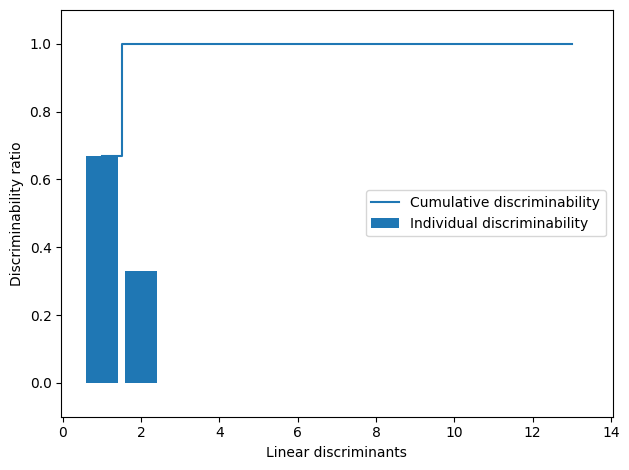

In [31]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, align='center',
        label='Individual discriminability')
plt.step(range(1, 14), cum_discr, where='mid',
         label='Cumulative discriminability')
plt.ylabel('Discriminability ratio')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

As we can see, the first two linear discriminants alone capture 100 percent of the useful
information in the Wine training dataset.

Let’s now stack the two most discriminative eigenvector columns to create the transformation matrix,
W

In [32]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


### Projecting examples onto the new feature space

**Using the transformation matrix W that we created in the previous subsection, we can now transform
the training dataset by multiplying the matrices**

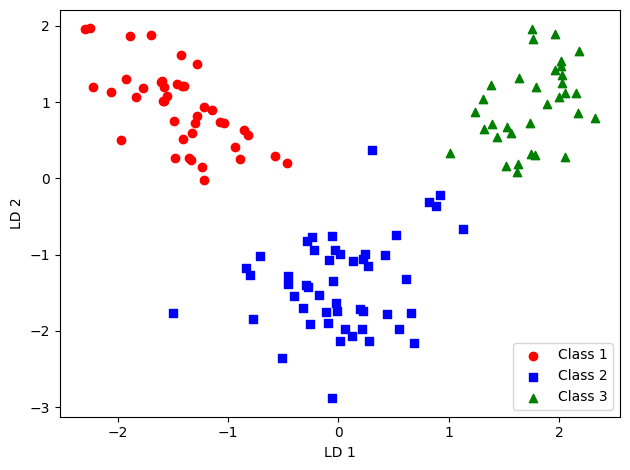

In [34]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### LDA via scikit-learn
Now, let’s look at the LDA class implemented in
scikit-learn

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


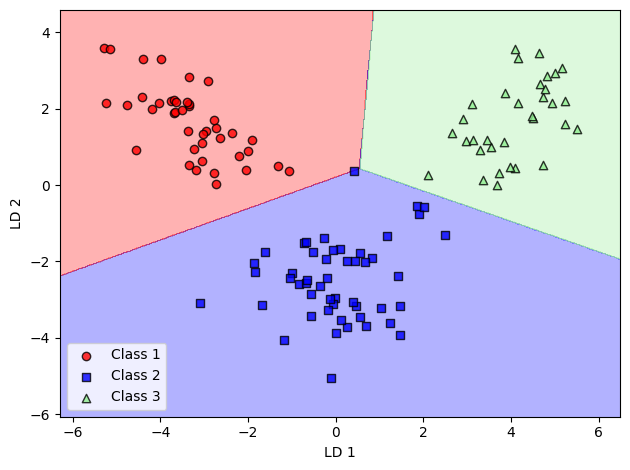

In [36]:
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

Let's take a look on the test dataset:

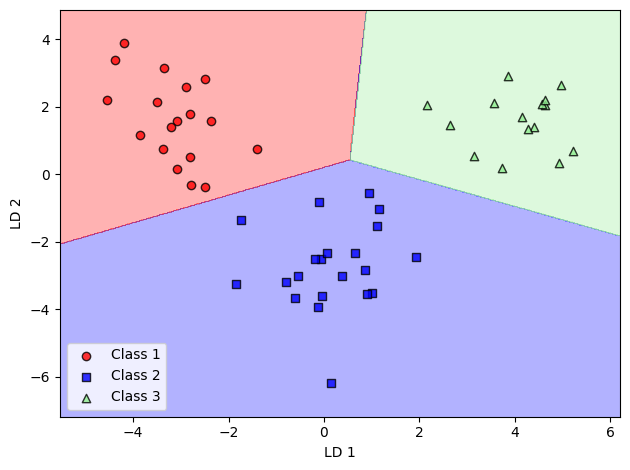

In [37]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## Nonlinear dimensionality reduction and visualization
In the previous section, we covered linear transformation techniques, such as PCA and LDA, for feature
extraction. In this section, we will discuss why considering nonlinear dimensionality reduction
techniques might be worthwhile.

### Visualizing data via t-distributed stochastic neighbor embedding

In a nutshell, t-SNE is modeling data points based on their pair-wise distances in the high-dimensional
(original) feature space. Then, it finds a probability distribution of pair-wise distances in the
new, lower-dimensional space that is close to the probability distribution of pair-wise distances in the
original space. Or, in other words, t-SNE learns to embed data points into a lower-dimensional space
such that the pairwise distances in the original space are preserved.

The following code shows a quick demonstration of how t-SNE can be applied to a 64-dimensional
dataset. First, we load the Digits dataset from scikit-learn, which consists of low-resolution handwritten
digits (the numbers 0-9):

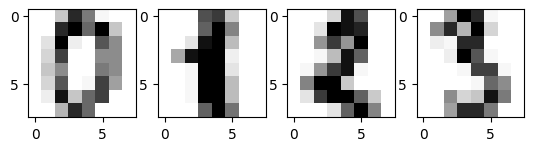

In [38]:
from sklearn.datasets import load_digits
digits = load_digits()

fig,ax = plt.subplots(1,4)
for i in range(4):
  ax[i].imshow(digits.images[i],cmap='Greys')
plt.show()

In [39]:
digits.data.shape

(1797, 64)

In [40]:
y_digits=digits.target
X_digits=digits.data

**Importing t-SNE class. Then fit a new tsne object**

In [41]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=123,init='pca')
X_digits_tsne = tsne.fit_transform(X_digits)

Using this code, we projected the 64-dimensional dataset onto a 2-dimensional space. We specified
init='pca', which initializes the t-SNE embedding using PCA as it is recommended

**Visualizing the 2D t-SNE embeddings**

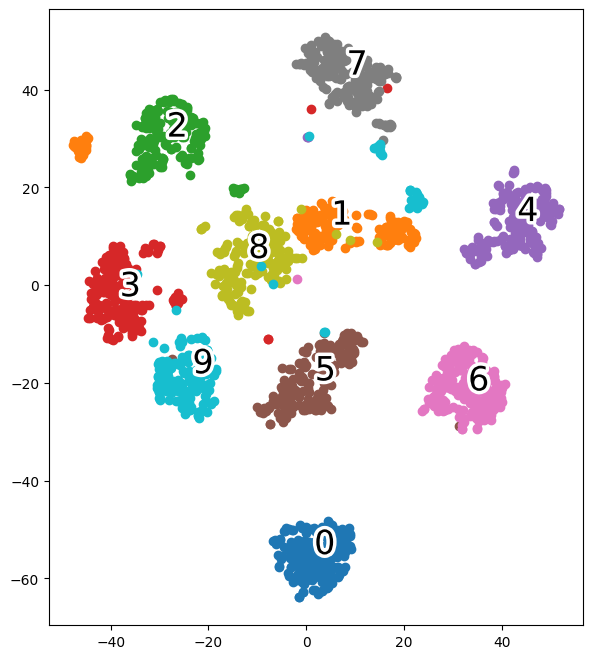

In [44]:
import matplotlib.patheffects as PathEffects
def plot_projection(x, colors):
  f = plt.figure(figsize=(8, 8))
  ax = plt.subplot(aspect='equal')
  for i in range (10):
    plt.scatter(x[colors == i,0], x[colors==i,1]) #  Tworzy maskę logiczną, wybierając tylko punkty, dla których colors jest równe i.

  for i in range(10):

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])

plot_projection(X_digits_tsne,y_digits)

Like PCA, t-SNE is an unsupervised method, and in the preceding code, we use the class labels y_digits
(0-9) only for visualization purposes via the functions color argument. Matplotlib’s PathEffects are
used for visual purposes, such that the class label is displayed in the center (via np.median) of data
points belonging to each respective digit.

As we can see, t-SNE is able to separate the different digits (classes) nicely, although not perfectly. It
might be possible to achieve better separation by tuning the hyperparameters. However, a certain
degree of class mixing might be unavoidable due to illegible handwriting